<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Sudoku

This tutorial includes everything you need to set up decision optimization engines, build constraint programming models.


When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of the **[Prescriptive Analytics for Python](https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html)**

>It requires a valid subscription to **Decision Optimization on the Cloud**. Try it for free [here](https://developer.ibm.com/docloud)

This notebook runs on Python 2 with Spark 2.1.

Table of contents:

-  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Download the library](#Step-1:-Download-the-library)
    *  [Step 2: Set up the engines](#Step-2:-Set-up-the-prescriptive-engine)
    -  [Step 3: Model the Data](#Step-3:-Model-the-data)
    -  [Step 4: Set up the prescriptive model](#Step-4:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with Decision Optimization solve service](#Solve-with-Decision-Optimization-solve-service)
    *  [Step 5: Investigate the solution and run an example analysis](#Step-5:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)
****

### Describe the business problem

* Sudoku is a logic-based, combinatorial number-placement puzzle.
* The objective is to fill a 9x9 grid with digits so that each column, each row,
and each of the nine 3x3 sub-grids that compose the grid contains all of the digits from 1 to 9.
* The puzzle setter provides a partially completed grid, which for a well-posed puzzle has a unique solution.

#### References
* See <a href="https://en.wikipedia.org/wiki/Sudoku" target="_blank" rel="noopener no referrer">here</a> for details.

*****
## How  decision optimization can help
* Prescriptive analytics technology recommends actions based on desired outcomes, taking into account specific scenarios, resources, and knowledge of past and current events. This insight can help your organization make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

+ For example:
    + Automate complex decisions and trade-offs to better manage limited resources.
    + Take advantage of a future opportunity or mitigate a future risk.
    + Proactively update recommendations based on changing events.
    + Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.


## Use decision optimization

### Step 1: Download the library

Run the following code to install Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming and Constraint Programming, referred to earlier.

In [1]:
import sys
try:
    import docplex.cp
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install docplex
    else:
        !pip install --user docplex

Note that the more global package <i>docplex</i> contains another subpackage <i>docplex.mp</i> that is dedicated to Mathematical Programming, another branch of optimization.

In [2]:
from docplex.cp.model import *
from sys import stdout

### Step 2: Set up the prescriptive engine

* Subscribe to the [Decision Optimization on Cloud solve service](https://developer.ibm.com/docloud).
* Get the service URL and your personal API key.

__Set your DOcplexcloud credentials:__
0. A first option is to set the DOcplexcloud url and key directly in the model source file *(see below)*
1. For a persistent setting, create a Python file __docloud_config.py__ somewhere that is visible from the __PYTHONPATH__

In [3]:
# Initialize IBM Decision Optimization credentials
SVC_URL = "" #ENTER YOUR URL HERE
SVC_KEY = "" #ENTER YOUR KEY HERE

### Step 3: Model the data

#### Grid range

In [4]:
GRNG = range(9)

#### Different problems

_zero means cell to be filled with appropriate value_

In [5]:
SUDOKU_PROBLEM_1 = ( (0, 0, 0,  0, 9, 0,  1, 0, 0),
                     (2, 8, 0,  0, 0, 5,  0, 0, 0),
                     (7, 0, 0,  0, 0, 6,  4, 0, 0),
                     (8, 0, 5,  0, 0, 3,  0, 0, 6),
                     (0, 0, 1,  0, 0, 4,  0, 0, 0),
                     (0, 7, 0,  2, 0, 0,  0, 0, 0),
                     (3, 0, 0,  0, 0, 1,  0, 8, 0),
                     (0, 0, 0,  0, 0, 0,  0, 5, 0),
                     (0, 9, 0,  0, 0, 0,  0, 7, 0),
                   )

SUDOKU_PROBLEM_2 = ( (0, 7, 0,  0, 0, 0,  0, 4, 9),
                     (0, 0, 0,  4, 0, 0,  0, 0, 0),
                     (4, 0, 3,  5, 0, 7,  0, 0, 8),
                     (0, 0, 7,  2, 5, 0,  4, 0, 0),
                     (0, 0, 0,  0, 0, 0,  8, 0, 0),
                     (0, 0, 4,  0, 3, 0,  5, 9, 2),
                     (6, 1, 8,  0, 0, 0,  0, 0, 5),
                     (0, 9, 0,  1, 0, 0,  0, 3, 0),
                     (0, 0, 5,  0, 0, 0,  0, 0, 7),
                   )

SUDOKU_PROBLEM_3 = ( (0, 0, 0,  0, 0, 6,  0, 0, 0),
                     (0, 5, 9,  0, 0, 0,  0, 0, 8),
                     (2, 0, 0,  0, 0, 8,  0, 0, 0),
                     (0, 4, 5,  0, 0, 0,  0, 0, 0),
                     (0, 0, 3,  0, 0, 0,  0, 0, 0),
                     (0, 0, 6,  0, 0, 3,  0, 5, 4),
                     (0, 0, 0,  3, 2, 5,  0, 0, 6),
                     (0, 0, 0,  0, 0, 0,  0, 0, 0),
                     (0, 0, 0,  0, 0, 0,  0, 0, 0)
                    )

In [6]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    VISU_ENABLED = True
except ImportError:
    VISU_ENABLED = False

In [7]:
def print_grid(grid):
    """ Print Sudoku grid """
    for l in GRNG:
        if (l > 0) and (l % 3 == 0):
           stdout.write('\n')
        for c in GRNG:
            v = grid[l][c]
            stdout.write('   ' if (c % 3 == 0) else ' ')
            stdout.write(str(v) if v > 0 else '.')
        stdout.write('\n')

In [8]:
def draw_grid(values):
    %matplotlib inline
    fig, ax = plt.subplots(figsize =(4,4))
    min_val, max_val = 0, 9
    R =  range(0,9)
    for l in R:
        for c in R:
            v = values[c][l]
            s = " "
            if v > 0:
                s = str(v)
            ax.text(l+0.5,8.5-c, s, va='center', ha='center')
        ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.grid()
    plt.show()

In [9]:
def display_grid(grid, name):
    stdout.write(name)
    stdout.write(":\n")
    if VISU_ENABLED:
        draw_grid(grid)
    else:
        print_grid(grid)

PROBLEM 1:


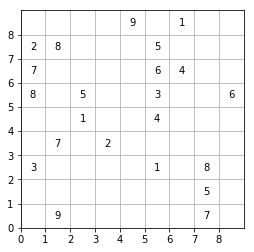

PROBLEM 2:


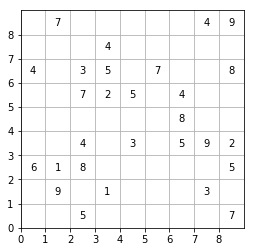

PROBLEM 3:


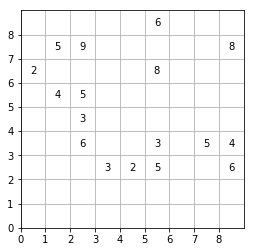

In [10]:
display_grid(SUDOKU_PROBLEM_1, "PROBLEM 1")
display_grid(SUDOKU_PROBLEM_2, "PROBLEM 2")
display_grid(SUDOKU_PROBLEM_3, "PROBLEM 3")

### Choose your preferred problem (SUDOKU_PROBLEM_1 or SUDOKU_PROBLEM_2 or SUDOKU_PROBLEM_3)
If you change the problem, ensure to re-run all cells below this one.

In [11]:
problem = SUDOKU_PROBLEM_3

### Step 4: Set up the prescriptive model

In [12]:
mdl = CpoModel(name="Sudoku")

#### Define the decision variables

In [13]:
grid = [[integer_var(min=1, max=9, name="C" + str(l) + str(c)) for l in GRNG] for c in GRNG]

#### Express the business constraints

Add alldiff constraints for lines

In [14]:
for l in GRNG:
    mdl.add(all_diff([grid[l][c] for c in GRNG]))

Add alldiff constraints for columns

In [15]:
for c in GRNG:
    mdl.add(all_diff([grid[l][c] for l in GRNG]))

Add alldiff constraints for sub-squares

In [16]:
ssrng = range(0, 9, 3)
for sl in ssrng:
    for sc in ssrng:
        mdl.add(all_diff([grid[l][c] for l in range(sl, sl + 3) for c in range(sc, sc + 3)]))

Initialize known cells

In [17]:
for l in GRNG:
    for c in GRNG:
        v = problem[l][c]
        if v > 0:
            grid[l][c].set_domain((v, v))

#### Solve with Decision Optimization solve service

In [18]:
print("\nSolving model....")
msol = mdl.solve(url=SVC_URL, 
                 key=SVC_KEY, TimeLimit=10)


Solving model....


### Step 5: Investigate the solution and then run an example analysis

Initial problem:


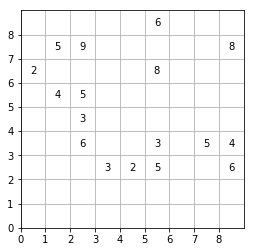

Solve time: 2.43791103363
Solution:


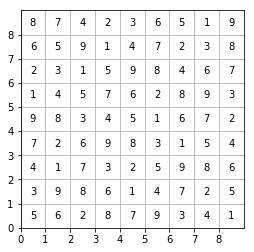

In [19]:
display_grid(problem, "Initial problem")
if msol:
    sol = [[msol[grid[l][c]] for c in GRNG] for l in GRNG]
    stdout.write("Solve time: " + str(msol.get_solve_time()) + "\n")
    display_grid(sol, "Solution")
else:
    stdout.write("No solution found\n")

## Summary

You learned how to set up and use the IBM Decision Optimization CPLEX Modeling for Python to formulate a Constraint Programming model and solve it with IBM Decision Optimization on the cloud.

## Author

<b>Olivier OUDOT, Ph.D.</b> in Logical Programming and IBM Master Inventor, joined the development team of the IBM Constraint Programming Optimizer in 2010 after a career of software development in military, space and telecommunications areas. He worked on the measurement of performances of the CP Optimizer solver before developing its Python interface, part of the DOcplex initiative (docplex.cp).


## References
* [CPLEX Modeling for Python documentation](https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html)
* [Decision Optimization on Cloud](https://developer.ibm.com/docloud/)
* Need help with DOcplex or to report a bug? Please go [here](https://developer.ibm.com/answers/smartspace/docloud)
* Contact us at dofeedback@wwpdl.vnet.ibm.com

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.